In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src/')
import ebtel_dem as ebd
import ebtel_plot_em as ebpe
from imp import reload
reload(ebd)
reload(ebpe)

<module 'ebtel_plot_em' from '/home/wtb2/Documents/EBTEL_analysis/src/ebtel_plot_em.py'>

#Emission Measure Slope Limits Testing

To get an accurate measure of the hotward slope in our plots of $\mathrm{EM}(T)$ generated by EBTEL, need to choose the limits over which the slope is calculated carefully.

First, we'll load in the data we need ($L=40$ Mm, $\alpha=-1.5$, electron heating) and then run statistics on our slope calculations.

In [33]:
loop_length = 40.0
alpha = 1.5
tpulse = 100.0
solver = 'rka4'
tn = np.arange(250,5250,250)
root_dir = '/data/datadrive2/EBTEL-2fluid_runs/'
species = 'electron'

First, we'll use the default values for the slope limits and see what those look like.

In [34]:
slope_limits = {'cool_lower':6.0,'cool_upper':6.6,
               'hot_lower':6.8,'hot_upper':7.25}
t_cool = np.linspace(slope_limits['cool_lower'],slope_limits['cool_upper'],1000)
t_hot = np.linspace(slope_limits['hot_lower'],slope_limits['hot_upper'],1000)

In [35]:
#load in the data
dema = ebd.DEMAnalyzer(root_dir,species,alpha,loop_length,tpulse,solver,Tn=tn,verbose=False,slope_limits=slope_limits)
dema.process_raw()
dema.em_statistics()

In [36]:
#process slope data
dema.many_slopes()
dema.slope_statistics()

Now, let's plot the resulting emission measure curves with the fit lines overlaid to assess the fit.

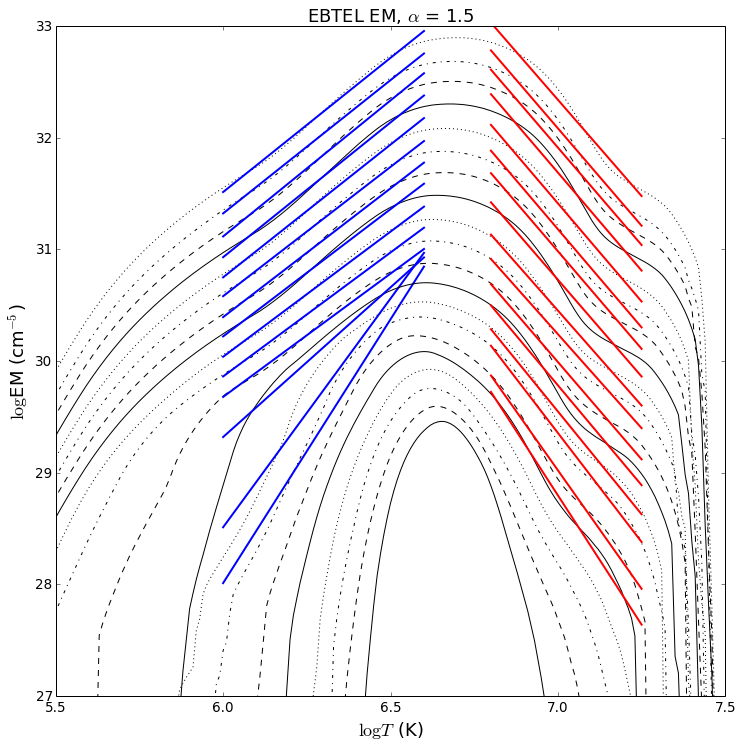

In [37]:
demp = ebpe.DEMPlotter(dema.temp_em,dema.em,alpha,Tn=tn)
fit_lines = {'t_cool':t_cool,'a_cool':dema.a_cool_mean,'b_cool':dema.b_cool_mean,
             't_hot':t_hot,'a_hot':dema.a_hot_mean,'b_hot':dema.b_hot_mean}
demp.plot_em_curves(dema.temp_mean,dema.em_mean,fit_lines=fit_lines)

In [53]:
temporary = np.array(dema.em_mean[-1])[np.where(np.isinf(dema.em_mean[-1]) == False)]
temporary_temp = np.array(dema.temp_mean[-1])[np.where(np.isinf(dema.em_mean[-1]) == False)]

(-0.5, 0.5)

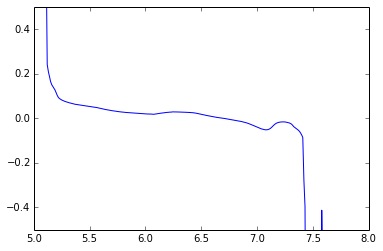

In [83]:
plt.plot(temporary_temp[:-1],np.diff(temporary))
plt.ylim([-0.5,0.5])

Let's try just shifting the hot slope limits upward a little bit and see if this makes a significant difference.

In [73]:
slope_limits = {'cool_lower':6.0,'cool_upper':6.6,
               'hot_lower':6.9,'hot_upper':7.3}
t_cool = np.linspace(slope_limits['cool_lower'],slope_limits['cool_upper'],1000)
t_hot = np.linspace(slope_limits['hot_lower'],slope_limits['hot_upper'],1000)
dema.slope_limits = slope_limits

In [74]:
#process slope data
dema.many_slopes()
dema.slope_statistics()

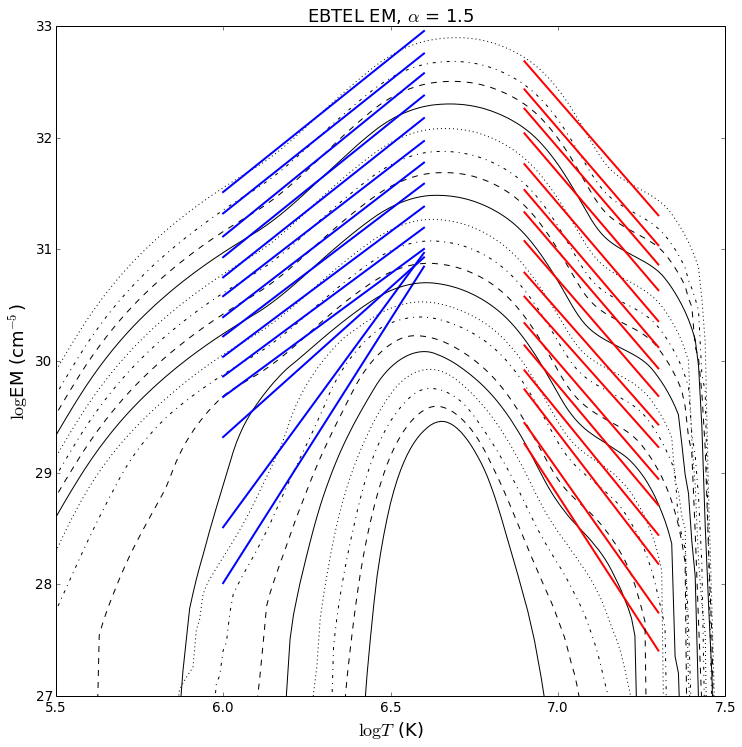

In [75]:
demp = ebpe.DEMPlotter(dema.temp_em,dema.em,alpha,Tn=tn)
fit_lines = {'t_cool':t_cool,'a_cool':dema.a_cool_mean,'b_cool':dema.b_cool_mean,
             't_hot':t_hot,'a_hot':dema.a_hot_mean,'b_hot':dema.b_hot_mean}
demp.plot_em_curves(dema.temp_mean,dema.em_mean,fit_lines=fit_lines)

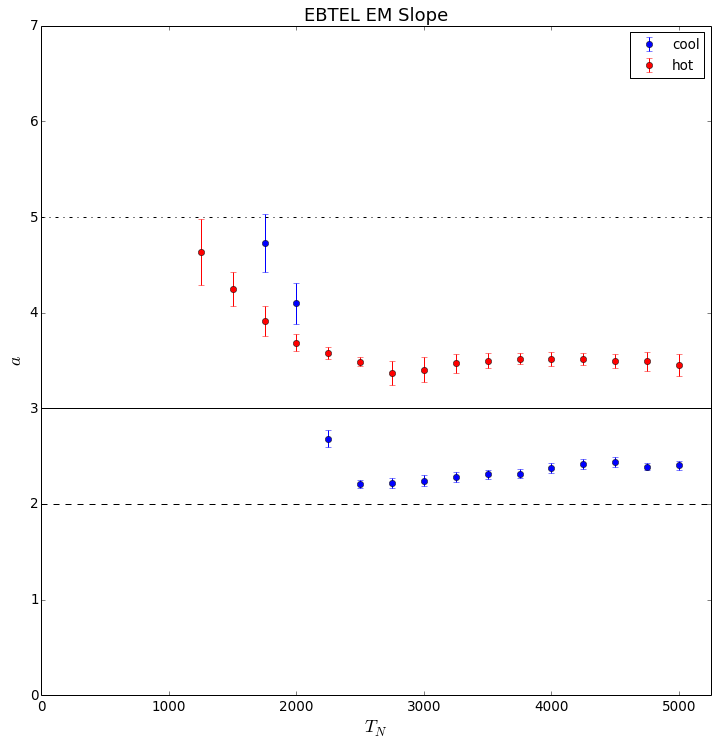

In [76]:
demp.plot_em_slopes(dema.a_cool_mean,dema.a_cool_std,dema.a_hot_mean,dema.a_hot_std)

But what would this look like for the single-species case? Limits may be too far to the right.

In [77]:
root_dir = '/data/datadrive2/EBTEL_C_runs/'
species = 'single'

In [78]:
#load in the data
dema_single = ebd.DEMAnalyzer(root_dir,species,alpha,loop_length,tpulse,solver,Tn=tn,verbose=False,slope_limits=slope_limits)
dema_single.process_raw()
dema_single.em_statistics()

In [79]:
#process slope data
dema_single.many_slopes()
dema_single.slope_statistics()

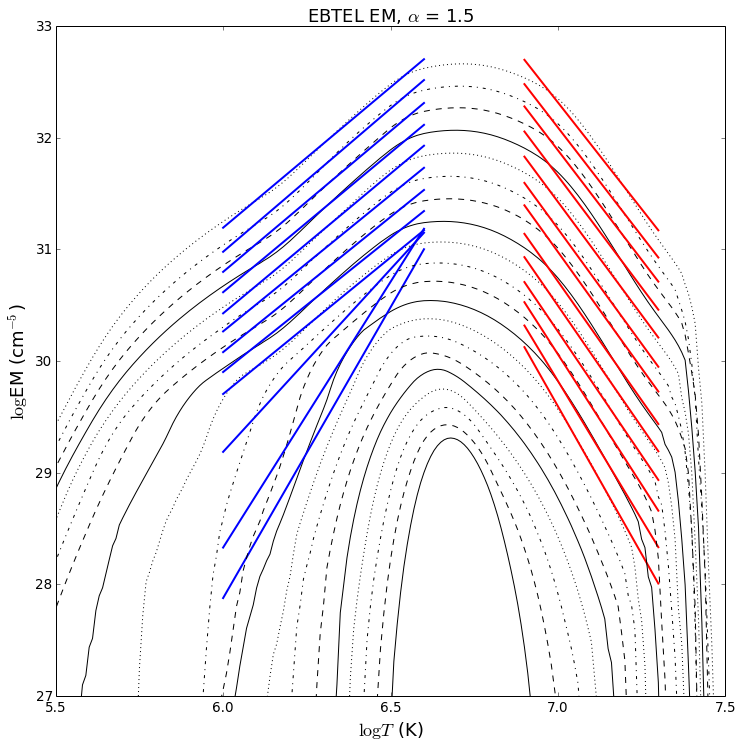

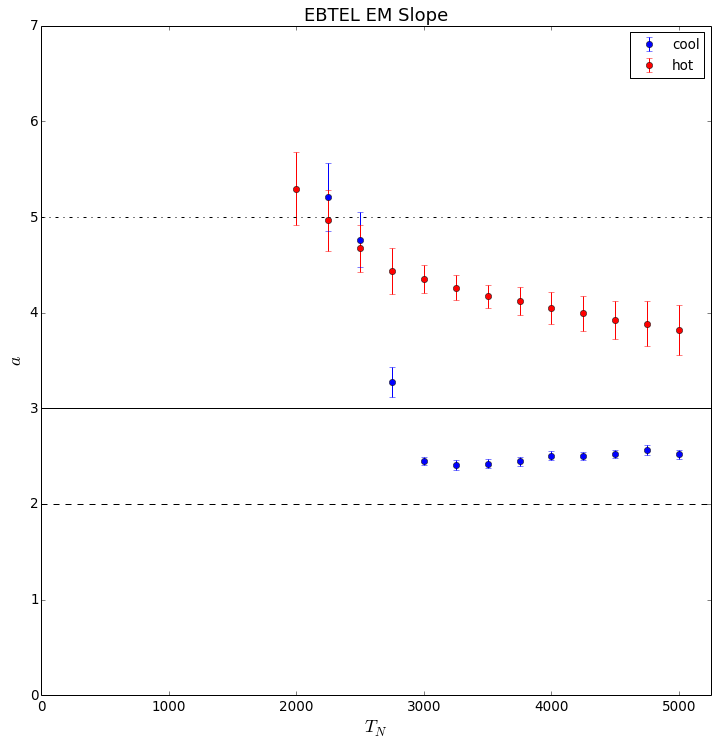

In [80]:
demp_single = ebpe.DEMPlotter(dema_single.temp_em,dema_single.em,alpha,Tn=tn)
fit_lines = {'t_cool':t_cool,'a_cool':dema_single.a_cool_mean,'b_cool':dema_single.b_cool_mean,
             't_hot':t_hot,'a_hot':dema_single.a_hot_mean,'b_hot':dema_single.b_hot_mean}
demp_single.plot_em_curves(dema_single.temp_mean,dema_single.em_mean,fit_lines=fit_lines)
demp_single.plot_em_slopes(dema_single.a_cool_mean,dema_single.a_cool_std,dema_single.a_hot_mean,dema_single.a_hot_std)

So using $6.9\leq\log(T)\leq7.3$ seems to work alright though the fits are still a little off in the single-species EBTEL-C case, giving a shallower slope than the hot shoulder actually has. 

We need to come up with a way where the limits are slightly altered for each value of $T_N$ such that the upper limit on the hot branch is the temperature at which $|\Delta(\mathrm{EM})|\geq\epsilon$, where $\epsilon$ is the threshold dropoff in $\mathrm{EM}$. The lower limit will then just be the upper limit $-0.4$.

In [ ]:
def calc_upper_hot_lim(mean_temp,mean_em):
    delta = 0.4 #spacing between upper and lower limits
    ninf_i = np.where(np.isinf(mean_em) == False)
    max_i = np.argmax(mean_em)
    